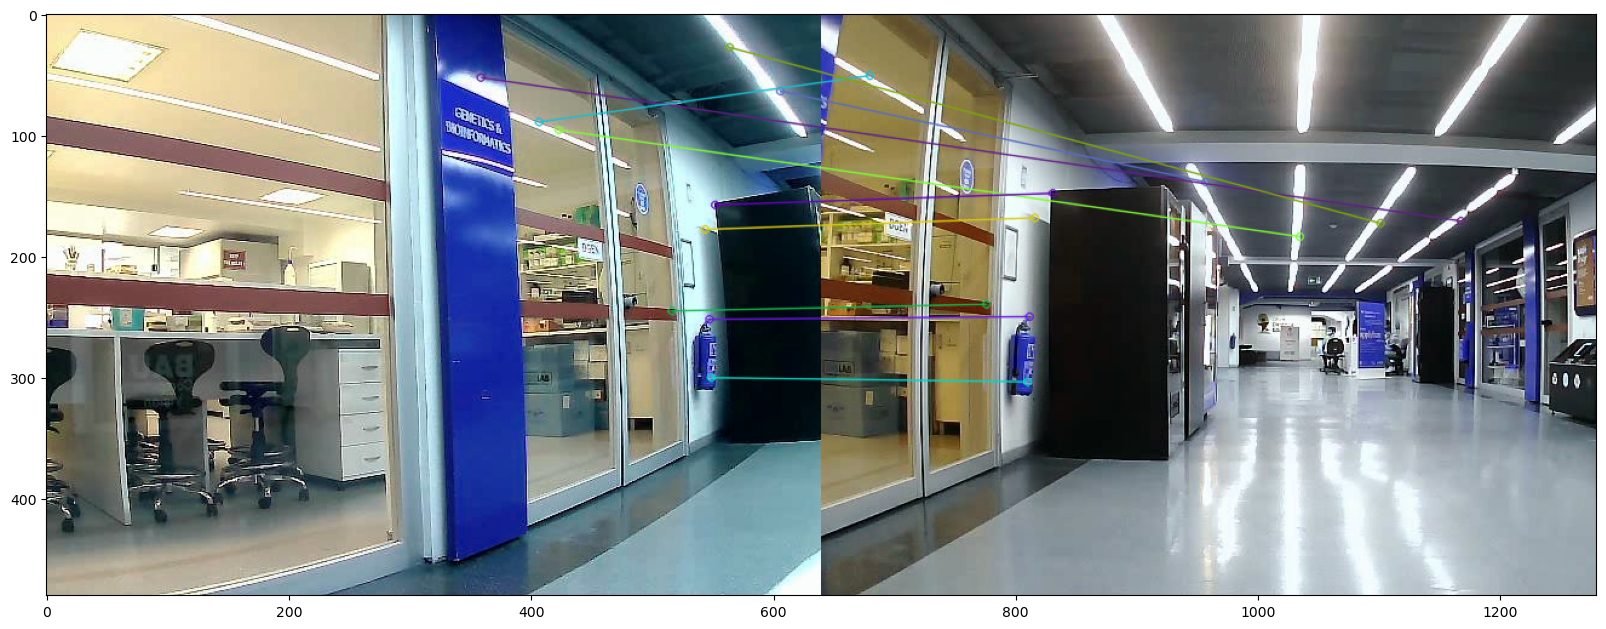

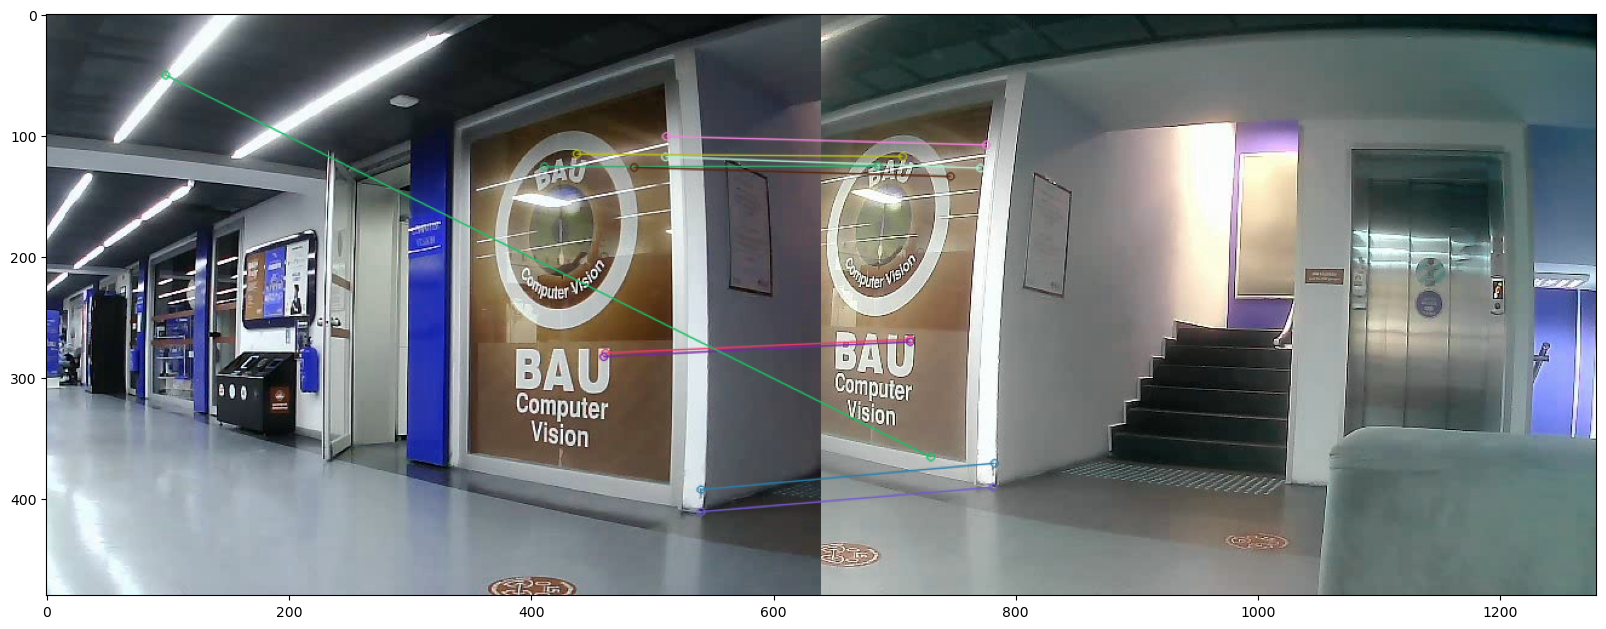

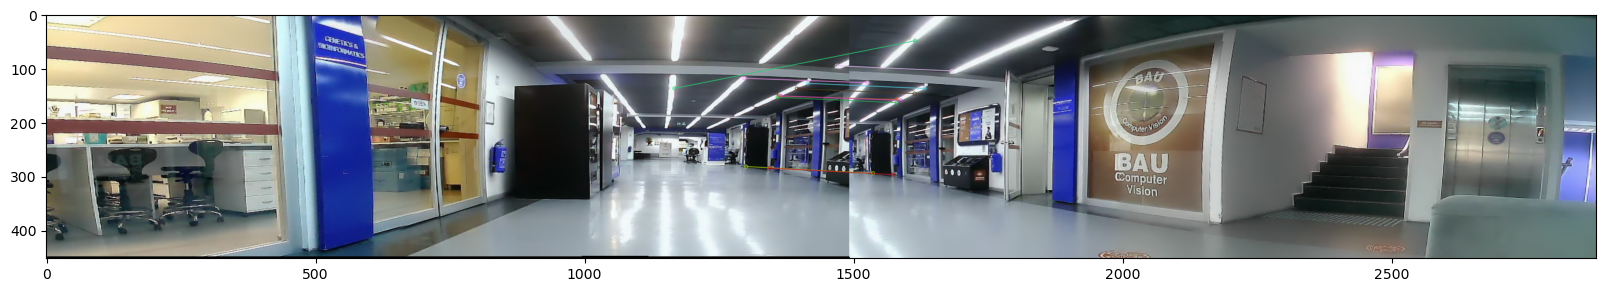

True

In [24]:



import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from stitching import Stitcher

def resize_image(image, width):
    aspect_ratio = width / image.shape[1]
    new_dimensions = (width, int(image.shape[0] * aspect_ratio))
    return cv.resize(image, new_dimensions, interpolation=cv.INTER_AREA)

def match_and_draw(img1, img2, detector_type="sift"):
    if detector_type == "sift":
        detector = cv.SIFT_create()
    elif detector_type == "orb":
        detector = cv.ORB_create()
    elif detector_type == "brisk":
        detector = cv.BRISK_create()
    else:
        raise ValueError(f"Unsupported detector type: {detector_type}")
    
    keypoints1, descriptors1 = detector.detectAndCompute(img1, None)
    keypoints2, descriptors2 = detector.detectAndCompute(img2, None)
    
    bf = cv.BFMatcher(cv.NORM_HAMMING if detector_type in ["orb", "brisk"] else cv.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)
    
    img_matches = cv.drawMatches(img1, keypoints1, img2, keypoints2, matches[:10], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    plt.figure(figsize=(20, 10))
    plt.imshow(img_matches)
    plt.show()

def undistort_and_rotate(image, camera_matrix, dist_coeffs, angle):
    # 获取新的相机矩阵
    new_camera_matrix, roi = cv.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (image.shape[1], image.shape[0]), 1, (image.shape[1], image.shape[0]))
    
    # 畸变矫正
    undistorted_image = cv.undistort(image, camera_matrix, dist_coeffs, None, new_camera_matrix)
    
    # 裁剪图像
    x, y, w, h = roi
    undistorted_image = undistorted_image[y:y+h, x:x+w]
    
    # 获取图像中心
    (h, w) = undistorted_image.shape[:2]
    center = (w // 2, h // 2)
    
    # 旋转矩阵
    M = cv.getRotationMatrix2D(center, angle, 1.0)
    
    # 旋转图像并裁剪黑边
    rotated_image = cv.warpAffine(undistorted_image, M, (w, h), flags=cv.INTER_LINEAR, borderMode=cv.BORDER_CONSTANT, borderValue=(0, 0, 0))
    
    return rotated_image

# 相机矩阵（需要根据具体相机参数调整）
camera_matrix = np.array([[800, 0, 640], [0, 800, 360], [0, 0, 1]], dtype=np.float32)

# 畸变系数（需要根据具体情况调整）
dist_coeffs_list = [
    np.array([-0.201, 0.59999991, 0, 0], dtype=np.float32),
    np.array([-0.2, 0.2, 0, 0], dtype=np.float32),
    np.array([-0.133, 0.233, 0, 0], dtype=np.float32),
    np.array([-0.133, 0.233, 0, 0], dtype=np.float32),
    np.array([0.03, 0.00, 0, 0], dtype=np.float32)
]

# 旋转角度（可以根据需要调整）
rotation_angles = [-1, 0, 0, 0]  # 示例角度，可以根据需要调整

# 读取图像并进行矫正和旋转
image_files = ["image1.jpg", "image2.jpg", "image3.jpg", "image4.jpg"]
images = []

for i in range(4):
    image = cv.imread(image_files[i])
    dist_coeffs = dist_coeffs_list[i]
    angle = rotation_angles[i]
    # undistorted_rotated_image = undistort_and_rotate(image, camera_matrix, dist_coeffs, angle)
    # images.append(undistorted_rotated_image)
    images.append(image)

# 将所有图像调整为图一的宽度
target_width = images[0].shape[1]
images = [resize_image(img, target_width) for img in images]

# 初始化拼接器，使用 BRISK 特征检测算法
stitcher = Stitcher(detector="sift", confidence_threshold=0.1)

# 先拼接图1和图2
match_and_draw(images[0], images[1], detector_type="brisk")
try:
    panorama1 = stitcher.stitch([images[0], images[1]])
except Exception as e:
    print(f"Error during stitching images 0 and 1: {e}")

# 再拼接图3和图4
match_and_draw(images[2], images[3], detector_type="brisk")
try:
    panorama2 = stitcher.stitch([images[2], images[3]])
except Exception as e:
    print(f"Error during stitching images 2 and 3: {e}")

# 最后将两次拼接的结果进行拼接
match_and_draw(panorama1, panorama2, detector_type="brisk")
try:
    final_panorama = stitcher.stitch([panorama1, panorama2])
except Exception as e:
    print(f"Error during stitching the panoramas: {e}")

# 保存拼接结果
cv.imwrite("final_panorama.jpg", final_panorama)





In [42]:

import cv2 as cv
import numpy as np
from stitching import Stitcher

# 读取图像
image_files = ["image1.jpg", "image2.jpg", "image3.jpg", "image4.jpg"]
images = [cv.imread(file) for file in image_files]

# 初始化拼接器，使用 SIFT 特征检测算法
stitcher = Stitcher(detector="orb", confidence_threshold=0.001)

# 先拼接图1和图2
try:
    panorama1 = stitcher.stitch([images[0], images[1]])
except Exception as e:
    print(f"Error during stitching images 0 and 1: {e}")
    exit(1)

# 再拼接图3和图4
try:
    panorama2 = stitcher.stitch([images[2], images[3]])
except Exception as e:
    print(f"Error during stitching images 2 and 3: {e}")
    exit(1)

# 最后将两次拼接的结果进行拼接
try:
    final_panorama = stitcher.stitch([panorama1, panorama2])
except Exception as e:
    print(f"Error during stitching the panoramas: {e}")
    exit(1)

# 保存拼接结果
cv.imwrite("final_panorama.jpg", final_panorama)

Error during stitching the panoramas: Camera parameters adjusting failed.


True

In [49]:

import cv2 as cv
import numpy as np
from stitching import Stitcher
import multiprocessing
import time

def stitch_images(image_files):
    # 读取图像
    images = [cv.imread(file) for file in image_files]
    
    # 初始化拼接器，使用 ORB 特征检测算法
    stitcher = Stitcher(detector="orb", confidence_threshold=0.001)
    
    # 先拼接图1和图2
    try:
        panorama1 = stitcher.stitch([images[0], images[1]])
    except Exception as e:
        print(f"Error during stitching images 0 and 1: {e}")
        return None
    
    # 再拼接图3和图4
    try:
        panorama2 = stitcher.stitch([images[2], images[3]])
    except Exception as e:
        print(f"Error during stitching images 2 and 3: {e}")
        return None
    
    # 最后将两次拼接的结果进行拼接
    try:
        final_panorama = stitcher.stitch([panorama1, panorama2])
    except Exception as e:
        print(f"Error during stitching the panoramas: {e}")
        return None
    
    return final_panorama

def save_image(image, index):
    if image is not None:
        cv.imwrite(f"final_panorama_{index}.jpg", image)

def process_images(index):
    image_files = ["image1.jpg", "image2.jpg", "image3.jpg", "image4.jpg"]
    final_panorama = stitch_images(image_files)
    save_image(final_panorama, index)

if __name__ == "__main__":
    start_time = time.time()
    
    # 创建多进程
    processes = []
    for i in range(16):
        p = multiprocessing.Process(target=process_images, args=(i,))
        processes.append(p)
        p.start()
    
    # 等待所有进程结束
    for p in processes:
        p.join()
    
    end_time = time.time()
    print(f"Total time for stitching 8 sets of images: {end_time - start_time} seconds")

Error during stitching the panoramas: Camera parameters adjusting failed.
Error during stitching the panoramas: Camera parameters adjusting failed.
Error during stitching the panoramas: Camera parameters adjusting failed.Error during stitching the panoramas: Camera parameters adjusting failed.Error during stitching the panoramas: Camera parameters adjusting failed.


Error during stitching the panoramas: Camera parameters adjusting failed.
Error during stitching the panoramas: Camera parameters adjusting failed.
Error during stitching the panoramas: Camera parameters adjusting failed.
Error during stitching the panoramas: Camera parameters adjusting failed.
Error during stitching the panoramas: Camera parameters adjusting failed.
Error during stitching the panoramas: Camera parameters adjusting failed.Error during stitching the panoramas: Camera parameters adjusting failed.
Error during stitching the panoramas: Camera parameters adjusting failed.
Error during stitching the panoramas: C

In [52]:

import cv2 as cv
import numpy as np
from stitching import Stitcher
import multiprocessing
import time
import os

def stitch_images(image_files):
    # 读取图像
    images = [cv.imread(file) for file in image_files]
    
    # 初始化拼接器，使用 ORB 特征检测算法
    stitcher = Stitcher(detector="orb", confidence_threshold=0.001)
    
    # 先拼接图1和图2
    try:
        panorama1 = stitcher.stitch([images[0], images[1]])
    except Exception as e:
        print(f"Error during stitching images 0 and 1: {e}")
        return None
    
    # 再拼接图3和图4
    try:
        panorama2 = stitcher.stitch([images[2], images[3]])
    except Exception as e:
        print(f"Error during stitching images 2 and 3: {e}")
        return None
    
    # 最后将两次拼接的结果进行拼接
    try:
        final_panorama = stitcher.stitch([panorama1, panorama2])
    except Exception as e:
        print(f"Error during stitching the panoramas: {e}")
        return None
    
    return final_panorama

def save_image(image, index, output_dir):
    if image is not None:
        cv.imwrite(os.path.join(output_dir, f"final_panorama_{index}.jpg"), image)

def process_images(index, output_dir):
    image_files = ["image1.jpg", "image2.jpg", "image3.jpg", "image4.jpg"]
    final_panorama = stitch_images(image_files)
    save_image(final_panorama, index, output_dir)

if __name__ == "__main__":
    start_time = time.time()
    
    # 创建输出文件夹
    output_dir = "./output"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 创建多进程
    processes = []
    for i in range(4):
        p = multiprocessing.Process(target=process_images, args=(i, output_dir))
        processes.append(p)
        p.start()
    
    # 等待所有进程结束
    for p in processes:
        p.join()
    
    end_time = time.time()
    print(f"Total time for stitching 32 sets of images: {end_time - start_time} seconds")


Error during stitching the panoramas: Camera parameters adjusting failed.
Error during stitching the panoramas: Camera parameters adjusting failed.
Error during stitching the panoramas: Camera parameters adjusting failed.
Error during stitching the panoramas: Camera parameters adjusting failed.
Total time for stitching 32 sets of images: 0.7163362503051758 seconds
